# Configurations

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'axes.linewidth': 1,
      'axes.labelpad': 6,
      'xtick.major.pad': 10,
      'xtick.major.width': 1,
      'ytick.major.width': 1,
      'lines.linewidth': 1,
      'font.size': 12,
      'axes.titlesize': 12,
      'axes.labelsize': 12,
      'xtick.labelsize': 12,
      'ytick.labelsize': 12,
      'legend.title_fontsize': 11,
      'legend.fontsize': 11,
      'figure.titlesize': 12,
      'figure.dpi': 72 * 3,
      'savefig.dpi': 72 * 4
      }
mpl.rcParams.update(rc)

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures', 'sfp_model', 'results_1D')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
lr = 0.005
max_epoch = 8000

In [57]:
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
voxels='pRFcenter'

# eccentricity bin information
e1, e2=0.5, 4
enum=7
if enum is 7:
    enum_range=range(7)
elif enum is 'log3':
    enum_range=range(3)
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
broderick_bin_list, broderick_bin_labels = tuning.get_bin_labels(1, 12, enum=11)


a = [3,2,0]
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
roi_pal.insert(0, (0.5,0.5,0.5))


# Load the data and model parameters

## NSD data: data, fitting results, precision

In [ ]:
# NSD data
f, m = [], []
for subj, roi in itertools.product(nsd_subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-{enum}_sub-avg_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'model', f'dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}_tavg-True.csv'))
    #file_name = f'/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/model/dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFcenter_tavg-True.csv'
    #f.append(file_name)
nsd_subj_df = utils.load_dataframes(f)
nsd_subj_df = nsd_subj_df.query('names != "mixtures"')
nsd_subj_df['ecc_bin'] = tuning.bin_ecc(nsd_subj_df['eccentricity'], bin_list=bin_list, bin_labels=bin_labels)
c_df = tuning.summary_stat_for_ecc_bin(nsd_subj_df,
                                        to_group= ['sub', 'ecc_bin', 'freq_lvl', 'names', 'vroinames', 'task'],
                                        to_bin=['betas', 'local_sf'],
                                        central_tendency='mean')
nsd_subj_df = nsd_subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
# NSD fitting results
pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(nsd_subj_list, roi_list, range(enum), ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', 'corrected', file_name))
nsd_tuning_df = tuning.load_all_models(pt_file_list, *args)

# NSD precision data
file_list = []
for subj, roi in itertools.product(nsd_subj_list, ['V1','V2','V3']):
    f = os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', 
                     f'precision-v_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

### Merge all the dataframes and fit a line to the weighted mean

In [ ]:
nsd_tuning_with_precision_df = nsd_tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
nsd_tuning_with_precision_df['pp'] = 1/ nsd_tuning_with_precision_df['mode']
nsd_fit_df = vis1D.fit_line_to_weighted_mean(nsd_tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

## Broderick data: data, fitting results, precision

In [6]:
# Broderick data
f, m = [], []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    file_name = f'tfunc-uncorrected_e1-1_e2-12_nbin-11_dset-broderick_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'before_w_a_correction', 'dataframes', 'broderick', 'binned', file_name))
broderick_subj_df = utils.load_dataframes(f)
broderick_subj_df = broderick_subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

# Broderick fitting results
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
pt_file_list = []
## drop the last bin data to avoid edge effects in the fitting
for subj, roi, curbin, stim_class in itertools.product(broderick_subj_list, ['V1'], range(10), ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'tfunc-uncorrected_model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-1_e2-12_nbin-11_curbin-{curbin}_dset-broderick_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'before_w_a_correction', 'sfp_model', 'results_1D', 'broderick', file_name))
broderick_tuning_df = tuning.load_all_models(pt_file_list, *args)

# precision
file_list = []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    f = os.path.join(output_dir, 'before_w_a_correction', 'dataframes', 'broderick', 'precision', 
                     f'precision-v_dset-broderick_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

In [7]:
broderick_tuning_with_precision_df = broderick_tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
broderick_tuning_with_precision_df['pp'] = 1/ broderick_tuning_with_precision_df['mode']
broderick_fit_df = vis1D.fit_line_to_weighted_mean(broderick_tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

## Merge the two datasets

In [7]:
# categorize based on dset and goal
broderick_tuning_with_precision_df['dset_type'] = 'Broderick et al. V1'
broderick_fit_df['dset_type'] = 'Broderick et al. V1'
broderick_tuning_with_precision_df['goal'] = 'Replication'
broderick_fit_df['goal'] = 'Replication'

nsd_tuning_with_precision_df['dset_type'] = nsd_tuning_with_precision_df['vroinames'].apply(lambda x: f'NSD {x}')
nsd_fit_df['dset_type'] = nsd_fit_df['vroinames'].apply(lambda x: f'NSD {x}')
nsd_tuning_with_precision_df['goal'] = nsd_tuning_with_precision_df['vroinames'].apply(lambda x: 'Replication' if x == 'V1' else 'Extension')
nsd_fit_df['goal'] = nsd_fit_df['vroinames'].apply(lambda x: 'Replication' if x == 'V1' else 'Extension')

tmp = nsd_tuning_with_precision_df.query('vroinames == "V1"')
tmp['goal'] = 'Extension'
nsd_tuning_with_precision_df = pd.concat((tmp, nsd_tuning_with_precision_df), axis=0)

tmp = nsd_fit_df.query('vroinames == "V1"')
tmp['goal'] = 'Extension'
nsd_fit_df = pd.concat((tmp, nsd_fit_df), axis=0)

tuning_with_precision_df = pd.concat((broderick_tuning_with_precision_df, 
                                      nsd_tuning_with_precision_df), axis=0)
fit_df = pd.concat((broderick_fit_df, nsd_fit_df), axis=0)

NameError: name 'broderick_tuning_with_precision_df' is not defined

# Plot tuning curves for NSD V1, V2, V3

In [47]:
c_df

,sub,ecc_bin,freq_lvl,names,vroinames,task,betas,local_sf
0,subj08,0.5-1.0 deg,0,annulus,V1,fixation,2.259125,1.319216
1,subj08,0.5-1.0 deg,0,annulus,V1,memory,1.610694,1.319216
2,subj08,0.5-1.0 deg,0,annulus,V2,fixation,2.074237,1.313905
3,subj08,0.5-1.0 deg,0,annulus,V2,memory,2.494857,1.313905
4,subj08,0.5-1.0 deg,0,annulus,V3,fixation,1.292563,1.282523
...,...,...,...,...,...,...,...,...
1003,subj08,3.5-4.0 deg,5,reverse spiral,V1,memory,1.500058,5.449118
1004,subj08,3.5-4.0 deg,5,reverse spiral,V2,fixation,1.434220,5.455321
1005,subj08,3.5-4.0 deg,5,reverse spiral,V2,memory,1.948394,5.455321
1006,subj08,3.5-4.0 deg,5,reverse spiral,V3,fixation,2.293002,5.472507


In [74]:
nsd_subj_df['normed_betas'] = nsd_subj_df.groupby(['sub','vroinames','ecc_bin'])['betas'].transform(lambda x: x / x.max())
#nsd_tuning_df['normed_betas'] = nsd_tuning_df.groupby(['sub','vroinames','ecc_bin'])['betas'].transform(lambda x: x / x.mean())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


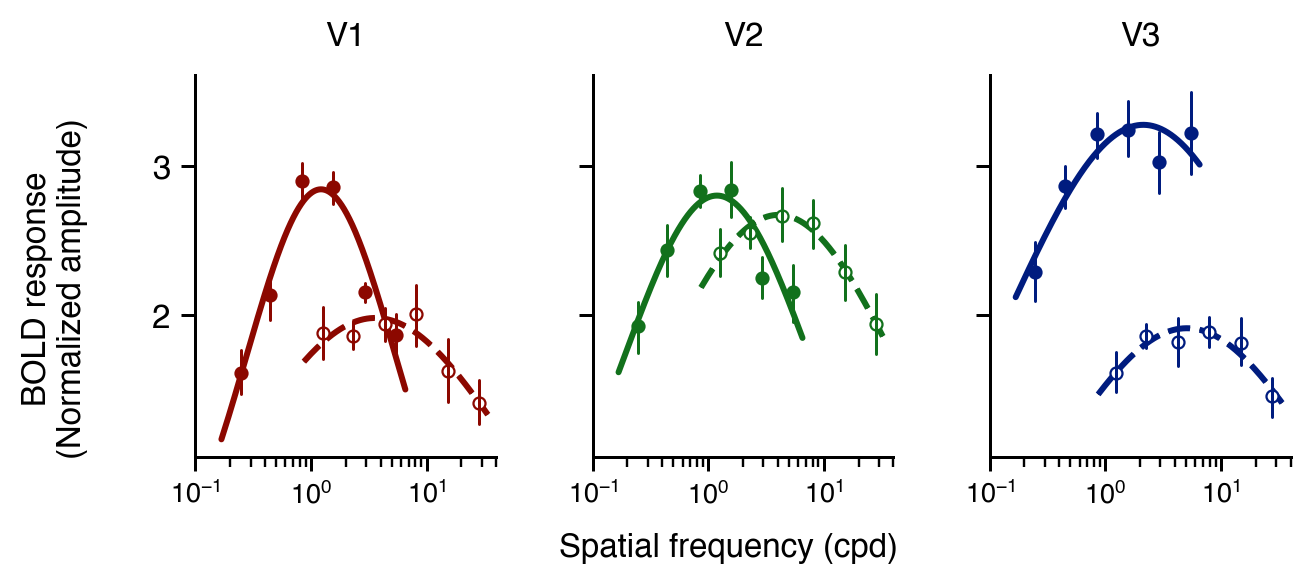

In [53]:
bins_to_plot = [bin_labels[k] for k in [0,6]]
fig, axes = vis1D.plot_tuning_curves_NSD_with_errorbar(c_df, nsd_tuning_df, y='betas', 
                             bins_to_plot=bins_to_plot, pal=roi_pal[1:], normalize=False,
                             save_path=os.path.join(fig_dir, 'subj08_tuning_curves_NSD_with_errorbar_normalize-False.svg'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


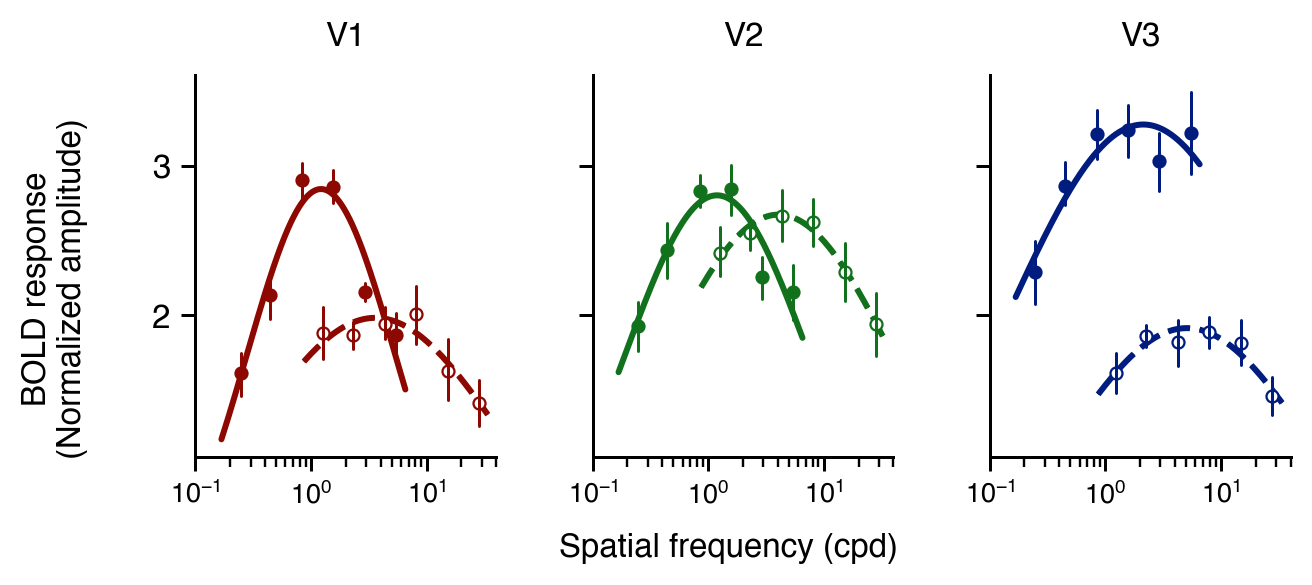

In [55]:
bins_to_plot = [bin_labels[k] for k in [0,6]]
fig, axes = vis1D.plot_tuning_curves_NSD_with_errorbar(c_df, nsd_tuning_df, y='betas', 
                             bins_to_plot=bins_to_plot, pal=roi_pal[1:], normalize=False,
                             save_path=os.path.join(fig_dir, 'subj08_tuning_curves_NSD_with_errorbar_normalize-False.svg'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


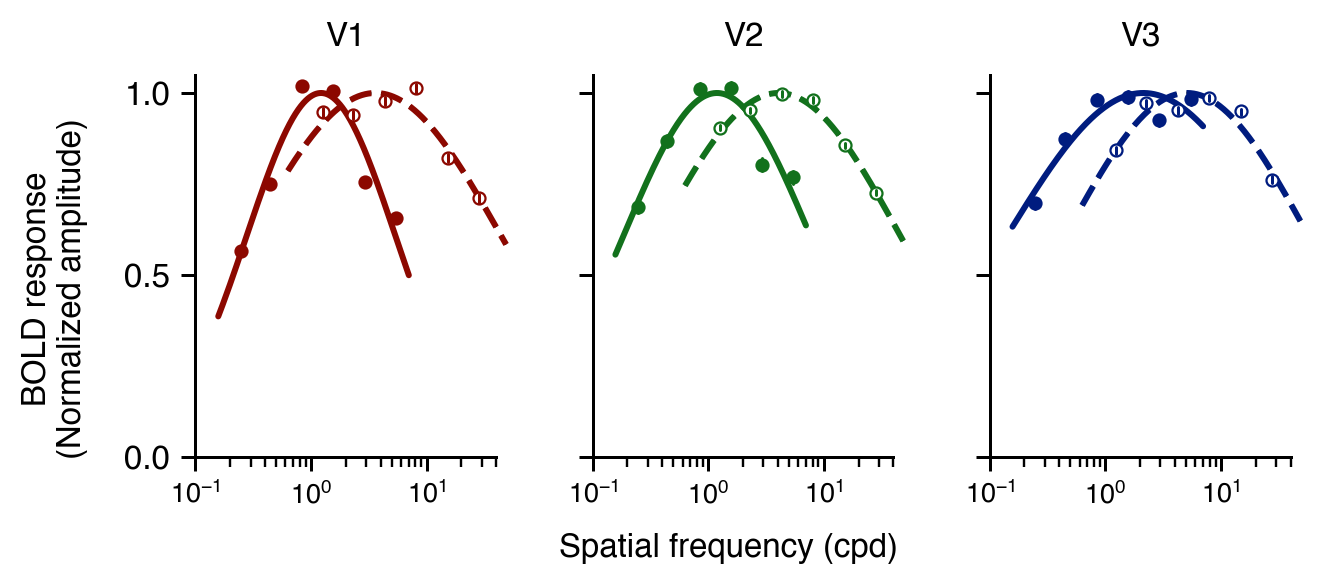

In [56]:
bins_to_plot = [bin_labels[k] for k in [0,6]]
fig, axes = vis1D.plot_tuning_curves_NSD_with_errorbar(nsd_subj_df, nsd_tuning_df, y='betas', 
                             bins_to_plot=bins_to_plot, pal=roi_pal[1:], normalize=True,
                             save_path=None)

In [24]:
nsd_subj_df.groupby(['vroinames','freq_lvl'])['local_sf'].mean().reset_index()


,vroinames,freq_lvl,local_sf
0,V1,0,0.549755
1,V1,1,0.985651
2,V1,2,1.876980
3,V1,3,3.479082
4,V1,4,6.522268
5,V1,5,12.106046
6,V2,0,0.554397
7,V2,1,0.993975
8,V2,2,1.892830
9,V2,3,3.508461


In [48]:
fig_dir

'/Volumes/server/Projects/sfp_nsd/derivatives/figures/sfp_model/results_1D'

(<Figure size 1404x561.6 with 3 Axes>,
 array([<AxesSubplot:title={'center':'V1'}>,
        <AxesSubplot:title={'center':'V2'}>,
        <AxesSubplot:title={'center':'V3'}>], dtype=object))

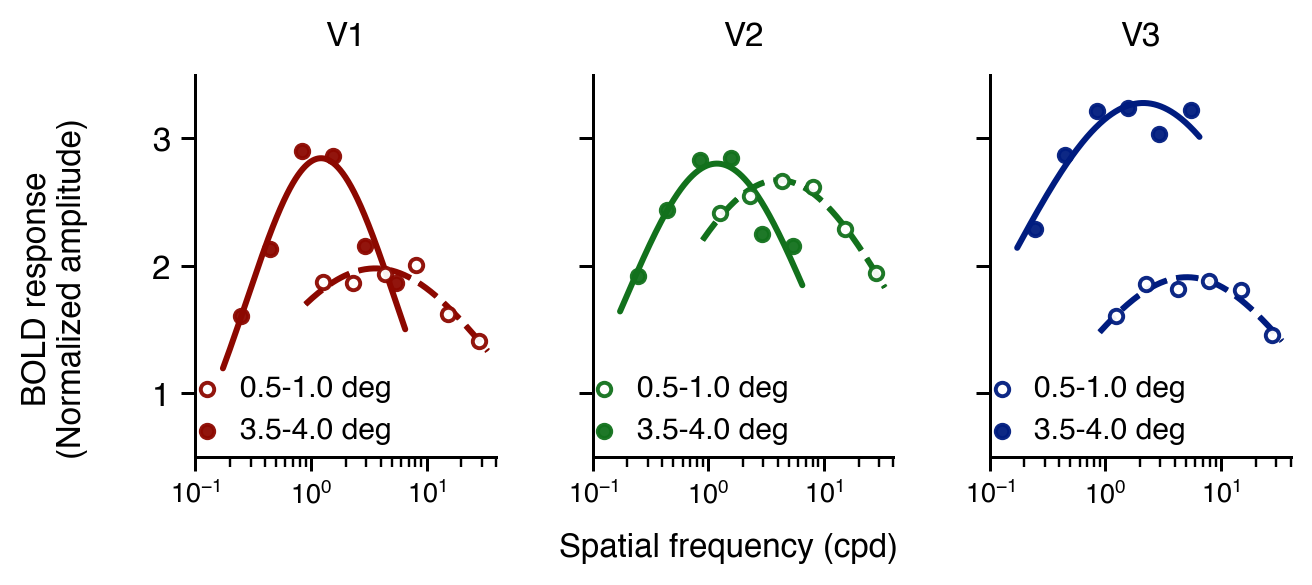

In [47]:
bins_to_plot = [bin_labels[k] for k in [0,6]]
vis1D.plot_tuning_curves_NSD(nsd_subj_df, nsd_tuning_df, subj='subj08', 
                             bins_to_plot=bins_to_plot, pal=roi_pal[1:], 
                             save_path=os.path.join(fig_dir, 'tuning_curves_NSD.svg'), normalize=False)